In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [6]:
"""
1 - gradient descent
2 - learning rate, maxiteration, tolerance, X, y
3 - add column 0
4 - normalize function
5 - sigmoid function
6 - cost function
7 - cost derivative
8 - predict function 
10 - evaluate function
    precision
    recall
"""

'\n1 - gradient descent\n2 - learning rate, maxiteration, tolerance, X, y\n3 - add column 0\n4 - normalize function\n5 - sigmoid function\n6 - cost function\n7 - cost derivative\n8 - predict function \n10 - evaluate function\n    precision\n    recall\n'

In [83]:
class LogisticRegression:
    def __init__(self, learningRate, maxIteration, tolerance, x_train, x_test, y_train, y_test):
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.tolerance = tolerance
        self.X_train, self.X_test, self.y_train, self.y_test = x_train, x_test, y_train, y_test
    
    def remove_index(self, i):
        #print(self.X_train[i])
        self.X_train = np.delete(self.X_train, i, axis=0)
        #print(self.X_train.shape)
        #print(self.y_train[i])
        self.y_train = np.delete(self.y_train, i, axis=0)
        #print(self.y_train.shape)
        return
    
    def normalizeTrain(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X - mean)/std
        # First normalize then add column of 0 otherwise you get division by 0 error
        X_norm = self.addX0(X_norm)
        return X_norm, mean, std

    def normalizeTest(self, X, mean, std):
        X_norm = (X - mean)/ std
        X_norm = self.addX0(X_norm)
        return X_norm

    """def readDataset(self):
        train_df = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2005 Data')
        test_df = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2007 Data')

        train_df, test_df = train_df.values, test_df.values

        train_X, train_y = train_df[:, 1:], train_df[:, 0]
        test_X, test_y = test_df[:, 1:], test_df[:, 0]
        return train_X, test_X, train_y, test_y"""

    def addX0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def sigmoid(self, z):
        sig = 1 / (1+ np.exp(-z))
        return sig

    def costFunction(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        loss = y * np.log(sig) + (1-y) * np.log(1-sig)
        cost = - loss.sum()
        return cost

    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig-y).dot(X)
        return grad

    def gradientDescent(self, X, y):
        losses = []
        prev_loss = float('inf')

        for i in tqdm(range(self.maxIteration), colour = 'red'):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_loss = self.costFunction(X, y)
            diff_loss = np.abs(prev_loss - current_loss)
            losses.append(current_loss)

            if diff_loss < self.tolerance:
                print("The model stopped learning")
                break

            prev_loss = current_loss
        
        self.plot()
        #self.plot3D()
        #self.scatterPlt()

        #self.plot_cost(losses) ---- need to find the code and add this later from the lecture

    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig) 

    def fit(self, exclude_index = None):
        if exclude_index is not None:
            self.remove_index(exclude_index)

        self.norm_X_train, mean, std = self.normalizeTrain(self.X_train)
        self.norm_X_test = self.normalizeTest(self.X_test, mean, std)

        self.w = np.ones(self.norm_X_train.shape[1], dtype = np.float64)
        print('Solving using gradient descent')
        self.gradientDescent(self.norm_X_train, self.y_train)

        print("Evaluating the training results")
        y_hat_train = self.predict(self.norm_X_train)

        recall, precision, f_score = self.evaluateFunction(self.y_train, y_hat_train)
        print("The recall of the model was {}".format(recall))
        print("The precision of the model was {}".format(precision))
        print("The F1 score of the model was {}".format(f_score))



    def evaluateFunction(self, y, y_hat):
        y = (y == 1)
        y_hat = (y_hat ==1)

        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()

        f_score = 2 * (precision * recall)/ (precision + recall)

        return recall, precision, f_score
    
    def plot(self):
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(self.X_train[:, 0], self.X_train[:, 1], 
                     self.sigmoid(self.norm_X_train.dot(self.w)), 
                     c = self.y_train[:], cmap='viridis', s=100);

        ax.set_xlim3d(55, 80)
        ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)

    
    
    def scatterPlt(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(self.X_train[:, 0], self.X_train[:, 1], 
                   c=self.y_train[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')
        

    def plot3D(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(self.X_train[:, 0], self.X_train[:, 1], 
                   c=self.y_train[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()

    
    # def plot function
    # def plot 3d


In [84]:
df_train = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2007 Data')
df_test = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2005 Data')

df_train, df_test = df_train.values, df_test.values

X_train, y_train = df_train[:, 1:], df_train[:, 0]
X_test, y_test = df_test[:, 1:], df_test[:, 0]

In [85]:
lr = LogisticRegression(tolerance=0.0, learningRate=0.1e-5, maxIteration= 10000, x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test)

Solving using gradient descent


100%|██████████| 10000/10000 [00:00<00:00, 32128.00it/s]


Evaluating the training results
The recall of the model was 0.9054054054054054
The precision of the model was 0.9436619718309859
The F1 score of the model was 0.9241379310344827


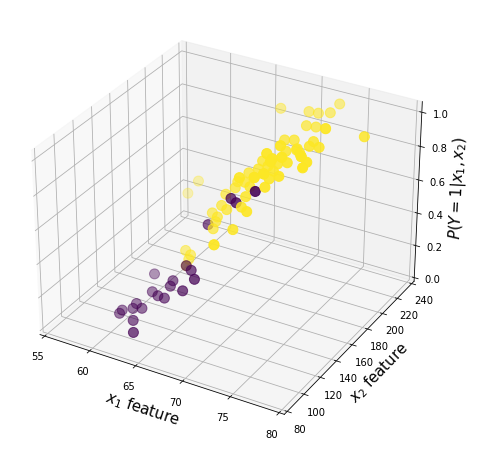

In [86]:
lr.fit()